# **MasterClass**

Este case sobre o preço do GLP foi desenvolvido a partir das aulas da startup Data Viking, ministradas em outubro/2023.

O produto final foi desenvolvido em cinco etapas principais:
- Baixar os dados (Dados Abertos do GovBr)
- Algoritmo: consolidar os dados; logs de processamento e envio a um banco SQL
- Análises Estatísticas: assimetria, série temporal e correlações
- Explorações: cotação do dólar, Indice Brent e Indice IPCA
- Produto: relatório tático com análises para insigts

__________
**O que é o GLP?**
<br>
O GLP, ou **Gás Liquefeito de Petróleo**, é um tipo de gás combustível composto principalmente por propano e butano. <br>
É um **subproduto** do processo de refino de **petróleo** e também pode ser obtido durante a extração de gás natural.


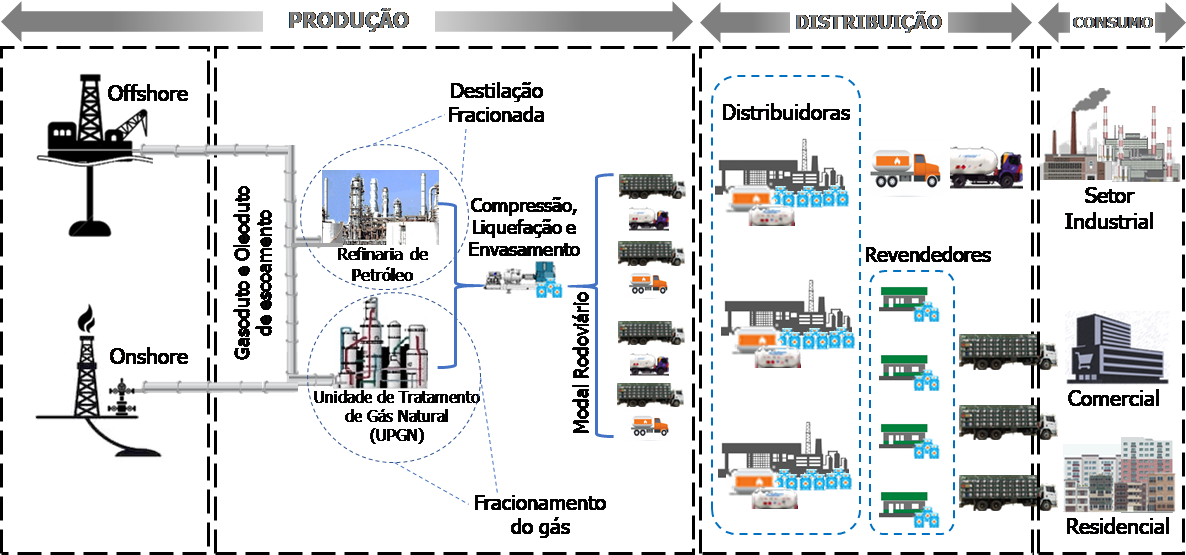

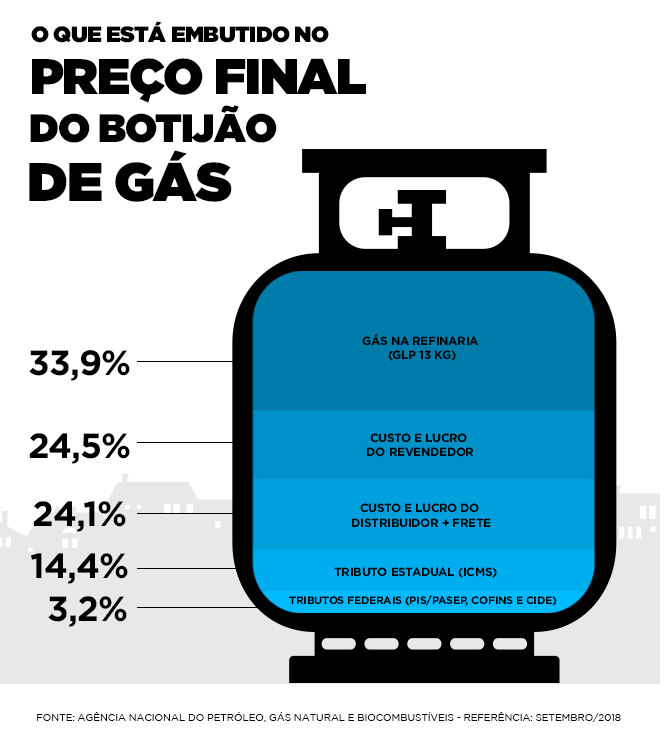

**Dados do GLP**
<br>
Como baixar os dados brutos
<br>
Link: https://dados.gov.br/dados/conjuntos-dados/serie-historica-de-precos-de-combustiveis-e-de-glp
<br>
<br>
Faça download dos período:
* 1º Semestre - 2020
* 2º Semestre - 2020
* 1º Semestre - 2021
* 2º Semestre - 2021
* 1º Semestre - 2022
* 2º Semestre - 2022
* 1º Semestre - 2023

In [1]:
# importando bibliotecas

import os
import pandas as pd
import numpy as np

#análises gráficas
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

#SQL
import sqlite3

import warnings
warnings.filterwarnings('ignore')

#estilo
plt.style.use('seaborn-dark')

In [2]:
#carregando os dados

teste = pd.read_csv('glp-2020-01.csv', sep = ';')
teste.head()

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,SE,MG,SAO SEBASTIAO DO PARAISO,REDE DE POSTOS ZERO IV LTDA.,00.883.226/0001-88,RODOVIA BR 491 KM 03,3101,NaN,ITAMARATI,37950-000,GLP,02/01/2020,65,NaN,R$ / 13 kg,COPAGAZ
1,S,RS,SANTA MARIA,SANTA LUCIA COMERCIO E PAVIMENTACOES LTDA,87.305.868/0001-88,RODOVIA RS 509,1200,KM 03,JOÃO GOULART,97095-000,GLP,03/01/2020,80,NaN,R$ / 13 kg,ULTRAGAZ
2,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0006-56,AVENIDA 25 DE AGOSTO,1350,NaN,25 DE AGOSTO,69980-000,GLP,02/01/2020,78,"68,72",R$ / 13 kg,AMAZONGÁS
3,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0004-94,AVENIDA LAURO MULLER,943,NaN,JOÃO ALVES,69980-000,GLP,02/01/2020,78,"68,72",R$ / 13 kg,AMAZONGÁS
4,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GLP,03/01/2020,82,"70,02",R$ / 13 kg,AMAZONGÁS


In [3]:
teste.shape

(114241, 16)

In [4]:
teste.isnull().sum()

Regiao - Sigla           0
Estado - Sigla           0
Municipio                0
Revenda                  0
CNPJ da Revenda          0
Nome da Rua              0
Numero Rua              17
Complemento          87070
Bairro                   0
Cep                      0
Produto                  0
Data da Coleta           0
Valor de Venda           0
Valor de Compra      84916
Unidade de Medida        0
Bandeira                 0
dtype: int64

In [5]:
# selecionando uma amostra dos dados
linhas = teste.shape[0]
colunas = teste.shape[1]

valores_nulos = teste.isnull().sum()
total_nulos = valores_nulos.sum()
colunas_nulas = valores_nulos[valores_nulos > 0].index

tipos_colunas = teste.dtypes

regioes = teste['Regiao - Sigla'].unique()
estados = teste['Estado - Sigla'].unique()

# construção de um dicionário - 'index':valor

Dicionario = {
    'Total_Registros' : linhas,
    'Total_Colunas' : colunas,
    'Total_linhas_ nulas' : total_nulos,
    'Colunas_nulas' : [colunas_nulas],
    'Tipo_campos' : tipos_colunas,
    'Estatistica_regioes' : [regioes],
    'Estatistica.estados' : [estados]
}

# Constroi dataframe sem index de referência
pd.DataFrame(Dicionario, index=[0])

,Total_Registros,Total_Colunas,Total_linhas_ nulas,Colunas_nulas,Tipo_campos,Estatistica_regioes,Estatistica.estados
0,114241,16,172003,"Index(['Numero Rua', 'Complemento', 'Valor de ...",NaN,"[SE, S, N, NE, CO]","[MG, RS, AC, AL, AM, BA, DF, ES, GO, MA, MS, M..."


In [6]:
def validar_arquivo(base_dados, nome_arquivo):
  '''
  Função irá verificar algumas estatísticas da ingestão de dados
  '''

  linhas = base_dados.shape[0]
  colunas = base_dados.shape[1]

  valores_nulos = base_dados.isnull().sum()
  total_nulos = valores_nulos.sum()
  colunas_nulas = valores_nulos[valores_nulos > 0].index

  tipos_colunas = base_dados.dtypes

  regioes = base_dados['Regiao - Sigla'].unique()
  estados = base_dados['Estado - Sigla'].unique()

  nome_arquivo = str(nome_arquivo)
  data = datetime.datetime.now().date()
  hora = datetime.datetime.now().time()


  Dicionario = {
      'Total_Registros' : linhas,
      'Total_Colunas' : colunas,
      'Total_linhas_ nulas' : total_nulos,
      'Colunas_nulas' : [colunas_nulas],
      'Tipo_campos' : tipos_colunas,
      'Estatistica_regioes' : [regioes],
      'Estatistica.estados' : [estados],
      'Nome Arquivo': nome_arquivo,
      'Data': data,
      'Hora': hora
  }

  log = pd.DataFrame(Dicionario, index=[0])

  return log;


## **Tratemento + Ingestão**

Nessa etapa:
1. Ler cada arquivo e empilhar em um único arquivo
2. Criar um banco de dados e uma tabela usando SQL
3. Levar os dados para o banco de dados

In [7]:
# estrutura para consolidar arquivos baixados

# local para buscar os arquivos baixados:
local = '/content/'

# variáveis de apoio
base_consolidada = pd.DataFrame()
base_log = pd.DataFrame()

# loop para percorrer os arquivos no diretório:
# acessa o SO da máquina, o caminho e local
for diretorio, subpastas, arquivos in os.walk(local):
  for arquivo in arquivos:
    if '.csv' in arquivo and 'glp' in arquivo:

      # empilhando os dados:
      base = pd.read_csv(local + f'{arquivo}', sep = ';')
      base_consolidada = pd.concat([base_consolidada , base])

      # base log
      base_log = pd.concat([base_log, validar_arquivo(base, arquivo)])

    else:
      pass

In [8]:
base_log

,Total_Registros,Total_Colunas,Total_linhas_ nulas,Colunas_nulas,Tipo_campos,Estatistica_regioes,Estatistica.estados,Nome Arquivo,Data,Hora
0,114241,16,172003,"Index(['Numero Rua', 'Complemento', 'Valor de ...",NaN,"[SE, S, N, NE, CO]","[MG, RS, AC, AL, AM, BA, DF, ES, GO, MA, MS, M...",glp-2020-01.csv,2023-10-28,18:16:19.102652
0,60280,16,106237,"Index(['Complemento', 'Valor de Compra'], dtyp...",NaN,"[SE, S, N, NE, CO]","[SP, RJ, RS, AC, CE, DF, MA, MG, MS, PA, PB, P...",glp-2021-01.csv,2023-10-28,18:16:19.567245
0,89372,16,157691,"Index(['Numero Rua', 'Complemento', 'Bairro', ...",NaN,"[NE, S, SE, CO, N]","[CE, SC, MA, SP, PB, RS, PR, PE, RJ, GO, MT, R...",glp-2021-02.csv,2023-10-28,18:16:20.305467
0,67371,16,118718,"Index(['Numero Rua', 'Complemento', 'Bairro', ...",NaN,"[NE, CO, SE, S, N]","[PI, GO, MG, SP, SC, AM, PA, PB, PE, PR, RO, R...",glp-2022-02.csv,2023-10-28,18:16:20.843961
0,100133,16,176302,"Index(['Numero Rua', 'Complemento', 'Bairro', ...",NaN,"[SE, N, NE, S, CO]","[SP, AC, CE, MA, PA, RS, PR, GO, MG, PB, TO, B...",glp-2022-01.csv,2023-10-28,18:16:21.807431
0,45412,16,73510,"Index(['Numero Rua', 'Complemento', 'Valor de ...",NaN,"[S, N, NE, CO, SE]","[RS, AM, BA, DF, GO, MA, MS, PB, PR, SC, SP, C...",glp-2020-02.csv,2023-10-28,18:16:22.349935
0,105341,16,184286,"Index(['Complemento', 'Bairro', 'Valor de Comp...",NaN,"[CO, S, SE, NE, N]","[MS, RS, MG, CE, BA, DF, ES, MA, PA, PB, PE, P...",glp-2023-01.csv,2023-10-28,18:16:24.860889


In [9]:
base_consolidada.shape

(582150, 16)

In [10]:
base_consolidada.columns

Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')

In [11]:
[ loop for loop in base_consolidada.columns]

['Regiao - Sigla',
 'Estado - Sigla',
 'Municipio',
 'Revenda',
 'CNPJ da Revenda',
 'Nome da Rua',
 'Numero Rua',
 'Complemento',
 'Bairro',
 'Cep',
 'Produto',
 'Data da Coleta',
 'Valor de Venda',
 'Valor de Compra',
 'Unidade de Medida',
 'Bandeira']

In [12]:
# para substituir automaticamente o nome das colunas:

[ loop.replace(' - ', '_').replace(' ', '_') for loop in base_consolidada.columns]

['Regiao_Sigla',
 'Estado_Sigla',
 'Municipio',
 'Revenda',
 'CNPJ_da_Revenda',
 'Nome_da_Rua',
 'Numero_Rua',
 'Complemento',
 'Bairro',
 'Cep',
 'Produto',
 'Data_da_Coleta',
 'Valor_de_Venda',
 'Valor_de_Compra',
 'Unidade_de_Medida',
 'Bandeira']

In [13]:
base_consolidada.columns = [ loop.replace(' - ', '_').replace(' ', '_').lower() for loop in base_consolidada.columns]
base_consolidada.columns

Index(['regiao_sigla', 'estado_sigla', 'municipio', 'revenda',
       'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'complemento', 'bairro',
       'cep', 'produto', 'data_da_coleta', 'valor_de_venda', 'valor_de_compra',
       'unidade_de_medida', 'bandeira'],
      dtype='object')

In [14]:
base_consolidada.data_da_coleta = pd.to_datetime(base_consolidada.data_da_coleta, format='%d/%m/%Y', errors = 'coerce')

In [15]:
base_consolidada['ano_coleta'] = base_consolidada.data_da_coleta.dt.year
base_consolidada['mes_coleta'] = base_consolidada.data_da_coleta.dt.month

In [16]:
base_consolidada.head()

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_da_revenda,nome_da_rua,numero_rua,complemento,bairro,cep,produto,data_da_coleta,valor_de_venda,valor_de_compra,unidade_de_medida,bandeira,ano_coleta,mes_coleta
0,SE,MG,SAO SEBASTIAO DO PARAISO,REDE DE POSTOS ZERO IV LTDA.,00.883.226/0001-88,RODOVIA BR 491 KM 03,3101,NaN,ITAMARATI,37950-000,GLP,2020-01-02,65,NaN,R$ / 13 kg,COPAGAZ,2020,1
1,S,RS,SANTA MARIA,SANTA LUCIA COMERCIO E PAVIMENTACOES LTDA,87.305.868/0001-88,RODOVIA RS 509,1200,KM 03,JOÃO GOULART,97095-000,GLP,2020-01-03,80,NaN,R$ / 13 kg,ULTRAGAZ,2020,1
2,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0006-56,AVENIDA 25 DE AGOSTO,1350,NaN,25 DE AGOSTO,69980-000,GLP,2020-01-02,78,"68,72",R$ / 13 kg,AMAZONGÁS,2020,1
3,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0004-94,AVENIDA LAURO MULLER,943,NaN,JOÃO ALVES,69980-000,GLP,2020-01-02,78,"68,72",R$ / 13 kg,AMAZONGÁS,2020,1
4,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GLP,2020-01-03,82,"70,02",R$ / 13 kg,AMAZONGÁS,2020,1


In [17]:
# conecta ao banco de dados (que será criado a partir da lib sqlite3 se não existir)
conexao = sqlite3.connect('db_glp.db')

In [18]:
cursor = conexao.cursor()

In [19]:
query_sql = '''

  CREATE TABLE IF NOT EXISTS tab_dados_glp (
    regiao_sigla TEXT,
    estado_sigla TEXT,
    municipio TEXT,
    revenda TEXT,
    cnpj_da_revenda TEXT,
    nome_da_rua TEXT,
    numero_rua TEXT,
    complemento TEXT,
    bairro TEXT,
    cep TEXT,
    produto TEXT,
    data_da_coleta DATETIME,
    valor_de_venda INTEGER,
    valor_de_compra INTEGER,
    unidade_de_medida TEXT,
    bandeira TEXT,
    Ano_Coleto INTEGER,
    Mes_Coleto INTEGER
  )

'''

# obs: para rodar essa etapa novamente e criar outra tabela, é necessário abrir a conexão e cursor como indicado nas células acima

# cria a tabela
cursor.execute(query_sql)

# salva as alterações e fecha a conexão
conexao.commit()
conexao.close()

In [20]:
# para validar se a tabela foi criada:

# conecta ao db
conn = sqlite3.connect('db_glp.db')

cursor = conn.cursor()

# consulta para listar todas as tabelas existentes no db
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# recupera o resultado das consultas
tabelas = cursor.fetchall()

# nomes das tabelas
for tabela in tabelas:
  print(tabela[0])

# fecha a conexão:
conn.close()


tab_dados_glp


In [21]:
# para enviar os dados pro db

# cria a conexão novamente
conn = sqlite3.connect('db_glp.db')

# o método 'to_sql' do pandas irá auxiliar nessa tarefa de inserir os dados
base_consolidada.to_sql(
    'tab_dados_glp',
    conn,
    if_exists='replace',
    index=False
)

# fecha a conexão
conn.close()

# obs: na vida real, tomar cuidado com esse parâmetro 'replace', para não substituir tabelas importantes

In [22]:
# conectar ao db
conn = sqlite3.connect('db_glp.db')

query_sql = '''
  SELECT *
  FROM tab_dados_glp
  LIMIT 10
'''

pd.read_sql(query_sql, conn)

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_da_revenda,nome_da_rua,numero_rua,complemento,bairro,cep,produto,data_da_coleta,valor_de_venda,valor_de_compra,unidade_de_medida,bandeira,ano_coleta,mes_coleta
0,SE,MG,SAO SEBASTIAO DO PARAISO,REDE DE POSTOS ZERO IV LTDA.,00.883.226/0001-88,RODOVIA BR 491 KM 03,3101,None,ITAMARATI,37950-000,GLP,2020-01-02 00:00:00,65,None,R$ / 13 kg,COPAGAZ,2020,1
1,S,RS,SANTA MARIA,SANTA LUCIA COMERCIO E PAVIMENTACOES LTDA,87.305.868/0001-88,RODOVIA RS 509,1200,KM 03,JOÃO GOULART,97095-000,GLP,2020-01-03 00:00:00,80,None,R$ / 13 kg,ULTRAGAZ,2020,1
2,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0006-56,AVENIDA 25 DE AGOSTO,1350,None,25 DE AGOSTO,69980-000,GLP,2020-01-02 00:00:00,78,"68,72",R$ / 13 kg,AMAZONGÁS,2020,1
3,N,AC,CRUZEIRO DO SUL,CARDINAL E OLIVEIRA LTDA,03.608.766/0004-94,AVENIDA LAURO MULLER,943,None,JOÃO ALVES,69980-000,GLP,2020-01-02 00:00:00,78,"68,72",R$ / 13 kg,AMAZONGÁS,2020,1
4,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,None,AREAL,69906-119,GLP,2020-01-03 00:00:00,82,"70,02",R$ / 13 kg,AMAZONGÁS,2020,1
5,N,AC,RIO BRANCO,AUTO POSTO ACAUAN LTDA,00.524.999/0001-78,RODOVIA AC 40,1800,None,VILA ACRE,69902-450,GLP,2020-01-03 00:00:00,85,"70,02",R$ / 13 kg,AMAZONGÁS,2020,1
6,N,AC,RIO BRANCO,FARHAT & FARHAT LTDA,06.057.934/0001-46,ESTRADA SANTA INÊS,1036,None,BAIXA DA COLINA,69909-011,GLP,2020-01-03 00:00:00,83,"74,55",R$ / 13 kg,FOGAS,2020,1
7,N,AC,RIO BRANCO,AUTO POSTO TREVO LTDA,84.322.932/0001-40,ESTRADA APOLONIO SALES,S/N,None,VILA IVONETE,69914-610,GLP,2020-01-03 00:00:00,82,"74,55",R$ / 13 kg,FOGAS,2020,1
8,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,None,PLANALTO,57308-000,GLP,2020-01-02 00:00:00,65,"46,56",R$ / 13 kg,NACIONAL GÁS BUTANO,2020,1
9,N,AM,ITACOATIARA,POSTO LETICIA LTDA,07.651.914/0002-42,AVENIDA PARQUE,555,None,PEDREIRAS,69100-000,GLP,2020-01-02 00:00:00,86,"64,57",R$ / 13 kg,FOGAS,2020,1


In [23]:
# obs: bases de dados muito grande (~50mm de registros) talvez fiquei muito pesado criar mais variáveis.
# para fins analíticos, é mais indicado utilizar uma base de dados especializada

In [24]:
# conectar ao db
conn = sqlite3.connect('db_glp.db')

query_sql = '''
  SELECT *
  FROM tab_dados_glp
'''

base_dados = pd.read_sql(query_sql, conn)
base_dados.head()

conn.close()

## Análise exploratória

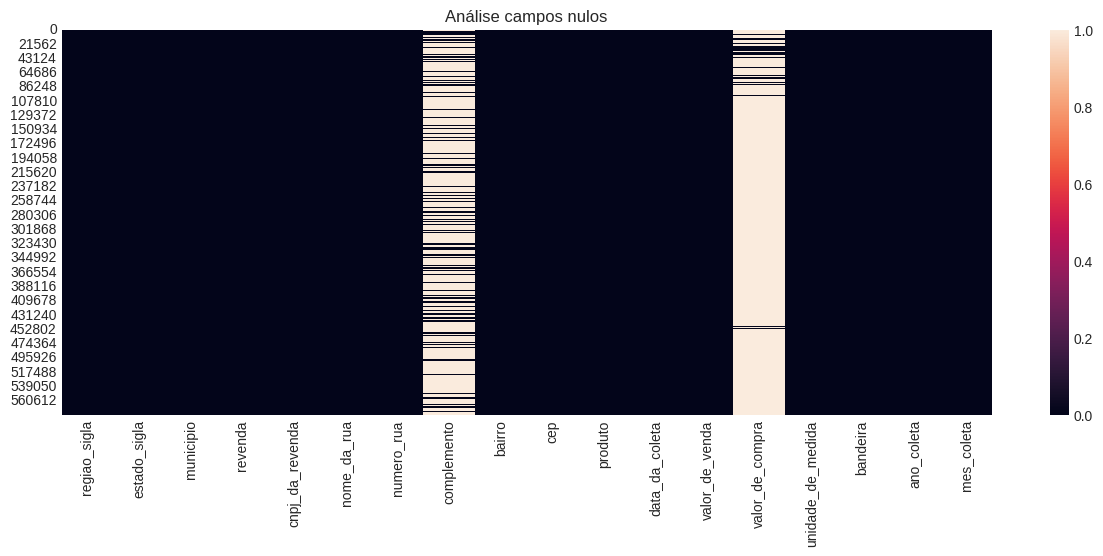

In [25]:
# Campos nulos
plt.figure(figsize=(15,5))
plt.title('Análise campos nulos')
sns.heatmap(base_dados.isnull());

In [26]:
# nesse caso, os dois atributos que apresentam dados nulos não têm relevância/não impactam para a análise

In [27]:
base_dados.dtypes

regiao_sigla         object
estado_sigla         object
municipio            object
revenda              object
cnpj_da_revenda      object
nome_da_rua          object
numero_rua           object
complemento          object
bairro               object
cep                  object
produto              object
data_da_coleta       object
valor_de_venda       object
valor_de_compra      object
unidade_de_medida    object
bandeira             object
ano_coleta            int64
mes_coleta            int64
dtype: object

In [28]:
# tirar as vírgulas dos valores de valor_de_compra para transformas em tipo numérico
base_dados.valor_de_venda = base_dados.valor_de_venda.apply( lambda Loop : Loop.replace(',','.'))
base_dados.valor_de_venda = pd.to_numeric(base_dados.valor_de_venda)

In [29]:
base_dados.valor_de_venda.dtypes

dtype('float64')

In [30]:
base_dados.valor_de_venda.describe()

# obs: estou desviando 19 reais em unidade do valor da média; o quanto o valor desvia da média

count    582150.000000
mean         94.902217
std          19.242097
min          49.900000
25%          78.000000
50%          98.000000
75%         110.000000
max         160.000000
Name: valor_de_venda, dtype: float64

**Regra do preço mensal**
* Vamos consilidar a média do mês

**Desvio Padrão** <br>
<p>
O desvio padrão é uma medida estatística que quantifica a dispersão ou variabilidade dos dados em um conjunto de dados.
</p>
<p>
Ele indica o quanto os valores em um conjunto de dados estão dispersos ou afastados da média (valor médio). Em outras palavras, o desvio padrão fornece uma medida de quão "espalhados" os dados estão ao redor da média.
</p>

In [31]:
base_dados.columns

Index(['regiao_sigla', 'estado_sigla', 'municipio', 'revenda',
       'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'complemento', 'bairro',
       'cep', 'produto', 'data_da_coleta', 'valor_de_venda', 'valor_de_compra',
       'unidade_de_medida', 'bandeira', 'ano_coleta', 'mes_coleta'],
      dtype='object')

In [32]:
base_dados.groupby(
    by=['ano_coleta', 'mes_coleta']
).agg(
    media = ('valor_de_venda', 'mean')
)

media
ano_coleta mes_coleta            
2020       1            70.626936
           2            70.789624
           3            70.843771
           4            70.855663
           5            70.471334
           6            70.581333
           7            70.805588
           8            71.045171
           10           74.971385
           11           75.240802
           12           76.121099
2021       1            77.590409
           2            80.537136
           3            83.946337
           4            85.949628
           5            86.442069
           6            88.036388
           7            92.769183
           8            94.419541
           9            98.726509
           10          101.806548
           11          103.535226
           12          103.293132
2022       1           103.552864
           2           103.479899
           3           110.563987
           4           114.481891
           5           113.783853
           6           113.542126
           7           112.905352
           8           112.277794
           9           113.160335
           10          110.501148
           11          110.464954
           12          109.647462
2023       1           109.100071
           2           108.813096
           3           108.221444
           4           108.327441
           5           108.425949
           6           104.475325

In [33]:
base_dados.groupby(
    by=['ano_coleta', 'mes_coleta']
).agg(
    quantidade = ('valor_de_venda', 'count'),
    media = ('valor_de_venda', 'mean'),
    mediana = ('valor_de_venda', 'median'),
    desvpad = ('valor_de_venda', 'std')
).reset_index()

,ano_coleta,mes_coleta,quantidade,media,mediana,desvpad
0,2020,1,20793,70.626936,70.000,8.021403
1,2020,2,17477,70.789624,70.000,7.970337
2,2020,3,19492,70.843771,70.000,7.901932
3,2020,4,19240,70.855663,70.000,7.551256
4,2020,5,17427,70.471334,70.000,7.422980
5,2020,6,19812,70.581333,70.000,7.589573
6,2020,7,19378,70.805588,70.000,7.434778
7,2020,8,12463,71.045171,70.000,7.642308
8,2020,10,1392,74.971385,75.000,8.570577
9,2020,11,4801,75.240802,75.000,8.290593


**Assimetria**

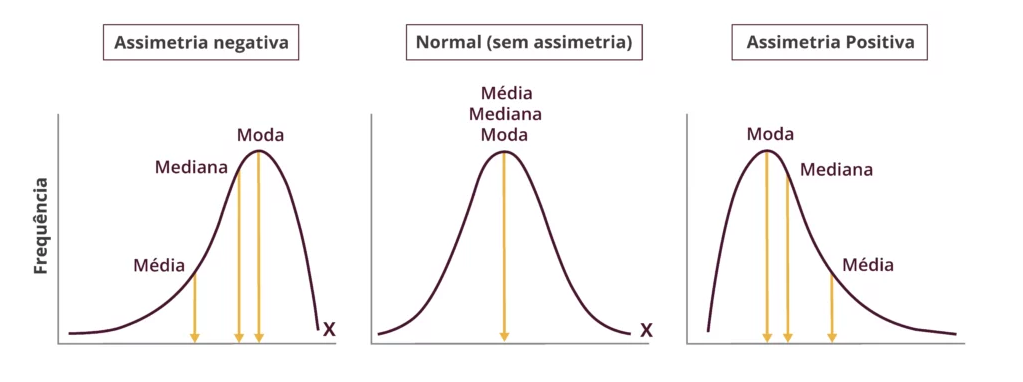

**Em termos práticos:**

1. Quando a **assimetria é igual a 0**, a distribuição é considerada simétrica, o que significa que os valores estão igualmente distribuídos ao redor da média, e não há inclinação para a direita ou para a esquerda.

2. Uma **assimetria negativa (menor que 0)** indica que a cauda da distribuição está mais longa à esquerda em comparação com a direita. Em outras palavras, a distribuição se estende mais para valores menores do que para valores maiores em relação à média.

3. Uma **assimetria positiva (maior que 0)** indicaria o oposto, ou seja, que a cauda da distribuição estaria mais longa à direita em comparação com a esquerda.

_______________________

Os benefícios de ter uma distribuição normal ou aproximadamente normal incluem:

1. **Facilidade de análise estatística**: Muitos métodos estatísticos e testes de hipóteses assumem que os dados seguem uma distribuição normal. Quando os dados se aproximam dessa distribuição, esses métodos podem ser aplicados com mais confiança e precisão.

2. **Interpretação intuitiva**: Distribuições normais são bem compreendidas e têm propriedades matemáticas bem estabelecidas, como a regra empírica (68-95-99.7), que descreve a proporção de dados dentro de determinados intervalos de desvio padrão da média.

3. **Facilita a previsão**: Muitos modelos estatísticos e de machine learning assumem que os erros seguem uma distribuição normal. Quando os erros são normalmente distribuídos, os modelos podem fazer previsões mais precisas.

(array([0.0018936 , 0.01413705, 0.01140765, 0.0110421 , 0.0182029 ,
        0.0227337 , 0.00846419, 0.00229941, 0.00053998, 0.00010594]),
 array([ 49.9 ,  60.91,  71.92,  82.93,  93.94, 104.95, 115.96, 126.97,
        137.98, 148.99, 160.  ]),
 <BarContainer object of 10 artists>)

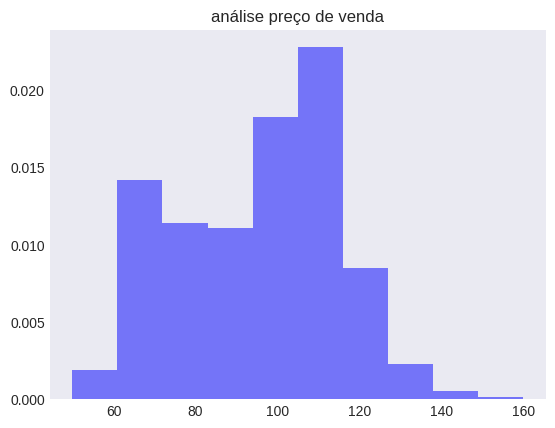

In [34]:
# criar um histograma
plt.title('análise preço de venda')
plt.hist(base_dados['valor_de_venda'], bins = 10, density = True, alpha=0.5, color = 'b')

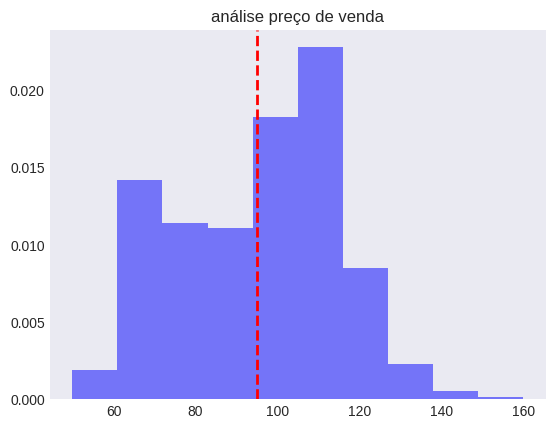

In [35]:
# adiciona linha de média no gráfico

plt.title('análise preço de venda')
plt.hist(base_dados['valor_de_venda'], bins = 10, density = True, alpha=0.5, color = 'b')

media_preco = base_dados['valor_de_venda'].mean()
plt.axvline(media_preco, color='r', linestyle = 'dashed', linewidth = 2, label='média')

Text(0, 0.5, 'frequencia')

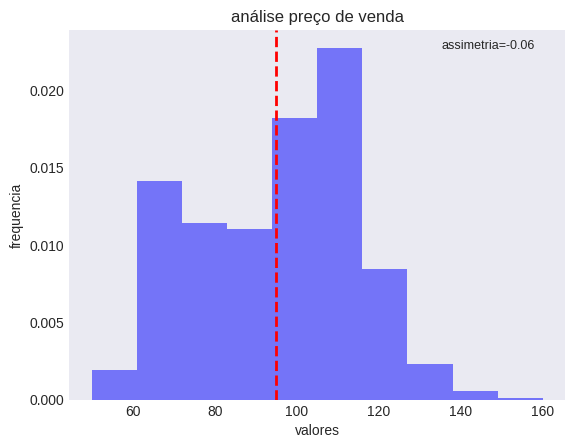

In [36]:
# verificando assimetria

plt.title('análise preço de venda')
plt.hist(base_dados['valor_de_venda'], bins = 10, density = True, alpha=0.5, color = 'b')

media_preco = base_dados['valor_de_venda'].mean()
plt.axvline(media_preco, color='r', linestyle = 'dashed', linewidth = 2, label='média')

assimetria = base_dados['valor_de_venda'].skew()
plt.annotate(f'assimetria={assimetria:.2f}', xy=(0.75,0.95), xycoords='axes fraction', fontsize=9)

plt.xlabel('valores')
plt.ylabel('frequencia')

In [37]:
# assemelha-se bastante a uma distribuição normal simétrica, com uma tendência para valores menores
# comclusão: importante testar a média para validar se ela pode ser usada como um indicador

In [38]:
# série temporal

serie_temp = base_dados.groupby(
    by=['ano_coleta', 'mes_coleta']
).agg(
    media = ('valor_de_venda', 'mean')
).reset_index()


serie_temp.head()

,ano_coleta,mes_coleta,media
0,2020,1,70.626936
1,2020,2,70.789624
2,2020,3,70.843771
3,2020,4,70.855663
4,2020,5,70.471334


In [39]:
serie_temp['periodo'] = serie_temp['ano_coleta'].astype('str') + '-' + serie_temp['mes_coleta'].astype('str') + '-' + '01'
serie_temp['periodo'] = pd.to_datetime(serie_temp['periodo'])
serie_temp.set_index('periodo', inplace=True)

serie_temp.head()

,ano_coleta,mes_coleta,media
periodo,,,
2020-01-01,2020,1,70.626936
2020-02-01,2020,2,70.789624
2020-03-01,2020,3,70.843771
2020-04-01,2020,4,70.855663
2020-05-01,2020,5,70.471334


In [40]:
# Gestão do Ministério da Fazenda
serie_temp['gestao'] = serie_temp['ano_coleta'].apply( lambda Loop : 'Paulo Guedes' if Loop < 2023 else 'Fernando Haddad')
serie_temp.head()

,ano_coleta,mes_coleta,media,gestao
periodo,,,,
2020-01-01,2020,1,70.626936,Paulo Guedes
2020-02-01,2020,2,70.789624,Paulo Guedes
2020-03-01,2020,3,70.843771,Paulo Guedes
2020-04-01,2020,4,70.855663,Paulo Guedes
2020-05-01,2020,5,70.471334,Paulo Guedes


In [41]:
serie_temp.tail()

,ano_coleta,mes_coleta,media,gestao
periodo,,,,
2023-02-01,2023,2,108.813096,Fernando Haddad
2023-03-01,2023,3,108.221444,Fernando Haddad
2023-04-01,2023,4,108.327441,Fernando Haddad
2023-05-01,2023,5,108.425949,Fernando Haddad
2023-06-01,2023,6,104.475325,Fernando Haddad


In [42]:
# comando shift desloca uma célula pra baixo da coluna que indicar

serie_temp['oscilação'] = (serie_temp.media/serie_temp.media.shift(1) - 1) *100
serie_temp.head()

,ano_coleta,mes_coleta,media,gestao,oscilação
periodo,,,,,
2020-01-01,2020,1,70.626936,Paulo Guedes,NaN
2020-02-01,2020,2,70.789624,Paulo Guedes,0.230347
2020-03-01,2020,3,70.843771,Paulo Guedes,0.076490
2020-04-01,2020,4,70.855663,Paulo Guedes,0.016786
2020-05-01,2020,5,70.471334,Paulo Guedes,-0.542410


Enriquecendo o dataframe (visão especializada) para análise

**Dados da Inflação do Brasil**
<br>
https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?t=series-historicas&utm_source=landing&utm_medium=explica&utm_campaign=inflacao#plano-real-mes

In [43]:
dados_inflacao = pd.read_excel('Base_Inflacao.xlsx')
dados_inflacao.head()

,periodo,No_Mes,3_Meses,6_Meses,Ano,12_Meses
0,2019-01-01,0.32,0.26,1.10,0.32,3.78
1,2019-02-01,0.43,0.90,1.63,0.75,3.89
2,2019-03-01,0.75,1.51,1.90,1.51,4.58
3,2019-04-01,0.57,1.76,2.02,2.09,4.94
4,2019-05-01,0.13,1.46,2.37,2.22,4.66


In [44]:
serie_temp = pd.merge(serie_temp.reset_index(), dados_inflacao, on='periodo', how='left')
serie_temp.head()

,periodo,ano_coleta,mes_coleta,media,gestao,oscilação,No_Mes,3_Meses,6_Meses,Ano,12_Meses
0,2020-01-01,2020,1,70.626936,Paulo Guedes,NaN,0.21,1.88,2.05,0.21,4.19
1,2020-02-01,2020,2,70.789624,Paulo Guedes,0.230347,0.25,1.62,2.20,0.46,4.01
2,2020-03-01,2020,3,70.843771,Paulo Guedes,0.076490,0.07,0.53,2.31,0.53,3.30
3,2020-04-01,2020,4,70.855663,Paulo Guedes,0.016786,-0.31,0.01,1.89,0.22,2.40
4,2020-05-01,2020,5,70.471334,Paulo Guedes,-0.542410,-0.38,-0.62,0.99,-0.16,1.88


**Dados do Dolar** <br>
https://www.aasp.org.br/suporte-profissional/indices-economicos/mensal/dolar/

In [45]:
dados_dolar = pd.read_excel('Base_Dolar.xlsx')
dados_dolar.head()

,periodo,Dolar
0,2019-01-01,3.9090
1,2019-02-01,3.7049
2,2019-03-01,3.7155
3,2019-04-01,3.8344
4,2019-05-01,3.8730


In [46]:
serie_temp = pd.merge(serie_temp.reset_index(), dados_dolar, on='periodo', how='left')
serie_temp.head()

,index,periodo,ano_coleta,mes_coleta,media,gestao,oscilação,No_Mes,3_Meses,6_Meses,Ano,12_Meses,Dolar
0,0,2020-01-01,2020,1,70.626936,Paulo Guedes,NaN,0.21,1.88,2.05,0.21,4.19,4.0949
1,1,2020-02-01,2020,2,70.789624,Paulo Guedes,0.230347,0.25,1.62,2.20,0.46,4.01,4.1622
2,2,2020-03-01,2020,3,70.843771,Paulo Guedes,0.076490,0.07,0.53,2.31,0.53,3.30,4.3163
3,3,2020-04-01,2020,4,70.855663,Paulo Guedes,0.016786,-0.31,0.01,1.89,0.22,2.40,4.7362
4,4,2020-05-01,2020,5,70.471334,Paulo Guedes,-0.542410,-0.38,-0.62,0.99,-0.16,1.88,5.2579


**Petróleo Brent Futuros Dados Históricos**
<br>
https://br.investing.com/commodities/brent-oil-historical-data

In [47]:
dados_petroleo = pd.read_excel('Base_Petroleo.xlsx')
dados_petroleo.head()

,periodo,Indice_Brent
0,2023-06-01,74.90
1,2023-05-01,72.66
2,2023-04-01,79.54
3,2023-03-01,79.77
4,2023-02-01,83.89


In [48]:
serie_temp = pd.merge(serie_temp.reset_index(), dados_petroleo, on='periodo', how='left')
serie_temp.head()

,level_0,index,periodo,ano_coleta,mes_coleta,media,gestao,oscilação,No_Mes,3_Meses,6_Meses,Ano,12_Meses,Dolar,Indice_Brent
0,0,0,2020-01-01,2020,1,70.626936,Paulo Guedes,NaN,0.21,1.88,2.05,0.21,4.19,4.0949,58.16
1,1,1,2020-02-01,2020,2,70.789624,Paulo Guedes,0.230347,0.25,1.62,2.20,0.46,4.01,4.1622,50.52
2,2,2,2020-03-01,2020,3,70.843771,Paulo Guedes,0.076490,0.07,0.53,2.31,0.53,3.30,4.3163,22.74
3,3,3,2020-04-01,2020,4,70.855663,Paulo Guedes,0.016786,-0.31,0.01,1.89,0.22,2.40,4.7362,25.27
4,4,4,2020-05-01,2020,5,70.471334,Paulo Guedes,-0.542410,-0.38,-0.62,0.99,-0.16,1.88,5.2579,35.33


In [49]:
# excluir colunas
serie_temp.drop(columns=['level_0','index'], inplace=True)

In [51]:
serie_temp.set_index('periodo', inplace=True)

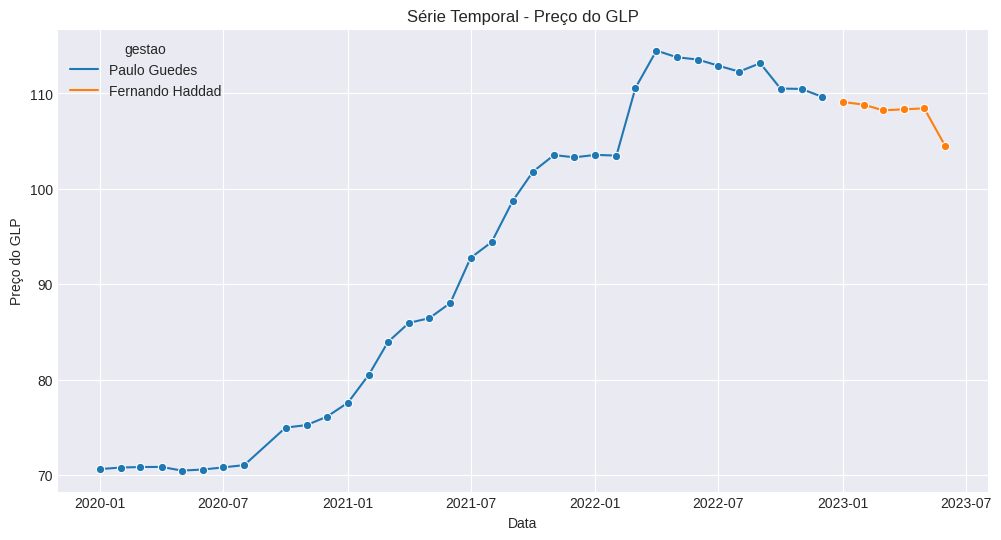

In [54]:
# Serie Temporal
plt.figure( figsize=(12, 6) )
sns.lineplot(
    data=serie_temp.reset_index(),
    x='periodo', y='media',
    hue='gestao', marker='o', linestyle='-')

plt.title('Série Temporal - Preço do GLP')
plt.xlabel('Data')
plt.ylabel('Preço do GLP')

plt.grid(True)

In [ ]:
'''
 insights:
 vê-se um aumento progressivo do preço do glp durante a pandemia (~ 07/2020 a 07/2022)
 a partir de 07/2022 começa a ter uma redução do preço que sai de R$ 120 e quase chega a R$ 100
 não necessariamente a gestão influenciou nessa variação de preço (importante ter cuidado com viés político e ideológico na análise)
'''

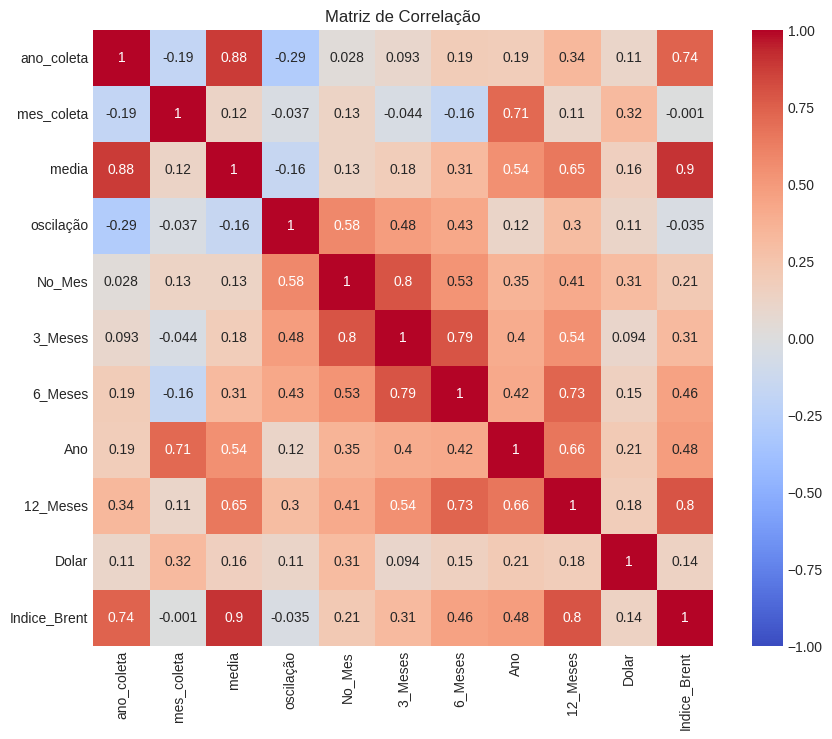

In [55]:
# análise de correlação
correlation_matrix = serie_temp.corr()

# Plot
plt.figure( figsize=(10, 8) )
sns.heatmap( correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação');

In [ ]:
'''
a correlação vai de -1 a 1;
ano e mês são variáveis de tempo e não fazem sentido nessa análise;
existem interferências externas no preço do GLP:
  - há uma correlação muito forte com o preço médio do glp x o preço do barril de petróleo
  - a inflação acumulada dos ultimos meses tbm apresenta uma correlação com o preço médio do glp
  - se pensar na cadeia produtiva, faz sentido o dolar estar relacionado. por isso essa variável foi considerada na análise, apesar do valor da correlação
'''

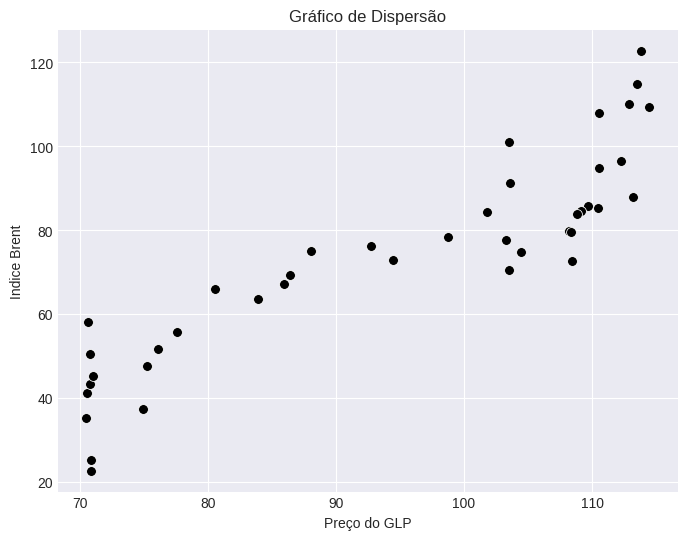

In [57]:
# GLP + Brent
plt.figure(figsize=(8, 6))
sns.scatterplot(data=serie_temp, x='media', y='Indice_Brent', color='black', marker='o', s=50)
plt.title('Gráfico de Dispersão')
plt.xlabel('Preço do GLP')
plt.ylabel('Indice Brent')
plt.grid(True)

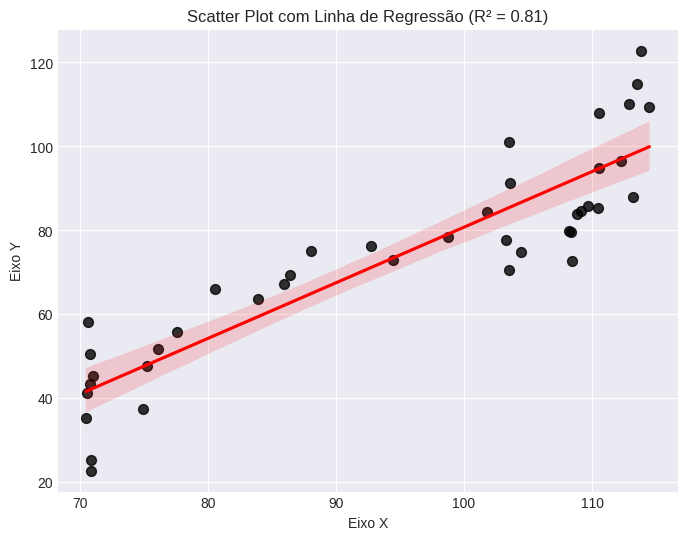

In [58]:
# Gráfico de dispersão + Linha da Regressão + r²

# Libs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Treinar uma regressão
x = serie_temp['Indice_Brent'].values.reshape(-1, 1)
y = serie_temp['media'].values.reshape(-1, 1)

# Treinao da Regressão
Regressor = LinearRegression()
Regressor.fit(x, y)

# Calcule o coeficiente de determinação (R²)
y_pred = Regressor.predict(x)
r2 = r2_score(y, y_pred)

# Tamanho da Imagem
plt.figure(figsize=(8, 6))

# Plot
sns.regplot(
    data=serie_temp, x='media', y='Indice_Brent', color='black',
    scatter_kws={'s': 50}, line_kws={'color': 'red'} )

plt.title(f'Scatter Plot com Linha de Regressão (R² = {r2:.2f})')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.grid(True)

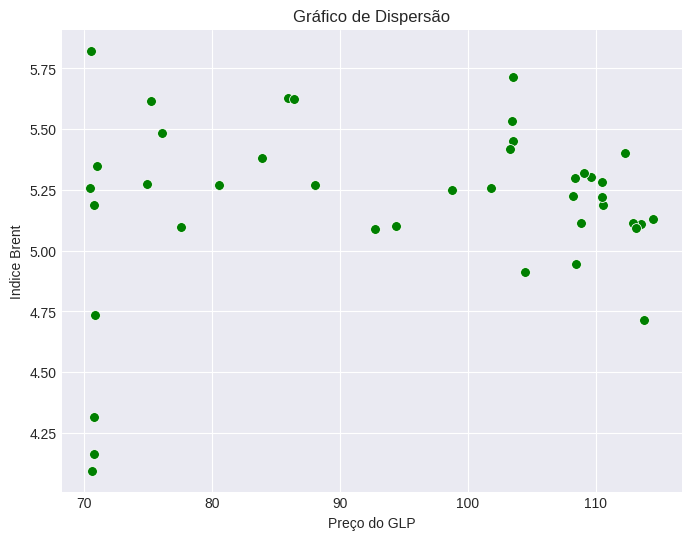

In [60]:
# GLP x Dólar
plt.figure(figsize=(8, 6))
sns.scatterplot(data=serie_temp, x='media', y='Dolar', color='green', marker='o', s=50)
plt.title('Gráfico de Dispersão')
plt.xlabel('Preço do GLP')
plt.ylabel('Indice Brent')
plt.grid(True)

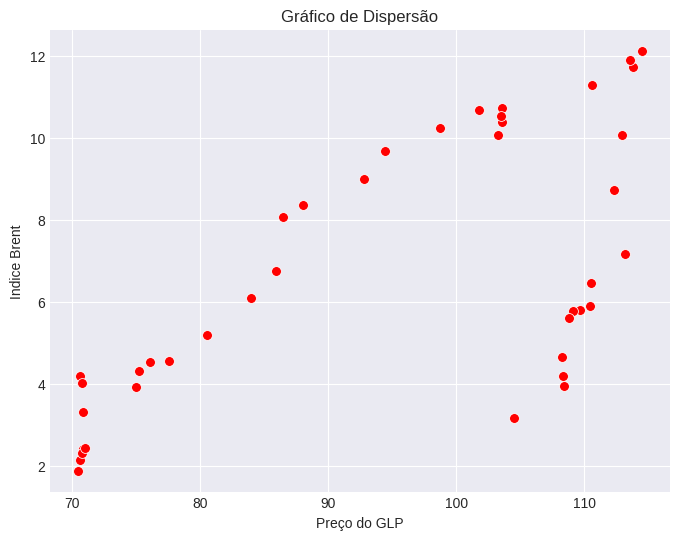

In [61]:
# GLP x IPCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=serie_temp, x='media', y='12_Meses', color='red', marker='o', s=50)
plt.title('Gráfico de Dispersão')
plt.xlabel('Preço do GLP')
plt.ylabel('Indice Brent')
plt.grid(True)

In [62]:
# Analisar o aumento do preço desde 2020
serie_temp['aumento_preco'] = serie_temp.media - serie_temp.media[0]
serie_temp['ano_mes'] = serie_temp['ano_coleta'].astype('str').apply(lambda Loop: Loop[2:4]) + '-' + serie_temp['mes_coleta'].astype('str')

serie_temp.head()

,ano_coleta,mes_coleta,media,gestao,oscilação,No_Mes,3_Meses,6_Meses,Ano,12_Meses,Dolar,Indice_Brent,aumento_preco,ano_mes
periodo,,,,,,,,,,,,,,
2020-01-01,2020,1,70.626936,Paulo Guedes,NaN,0.21,1.88,2.05,0.21,4.19,4.0949,58.16,0.000000,20-1
2020-02-01,2020,2,70.789624,Paulo Guedes,0.230347,0.25,1.62,2.20,0.46,4.01,4.1622,50.52,0.162687,20-2
2020-03-01,2020,3,70.843771,Paulo Guedes,0.076490,0.07,0.53,2.31,0.53,3.30,4.3163,22.74,0.216834,20-3
2020-04-01,2020,4,70.855663,Paulo Guedes,0.016786,-0.31,0.01,1.89,0.22,2.40,4.7362,25.27,0.228726,20-4
2020-05-01,2020,5,70.471334,Paulo Guedes,-0.542410,-0.38,-0.62,0.99,-0.16,1.88,5.2579,35.33,-0.155602,20-5


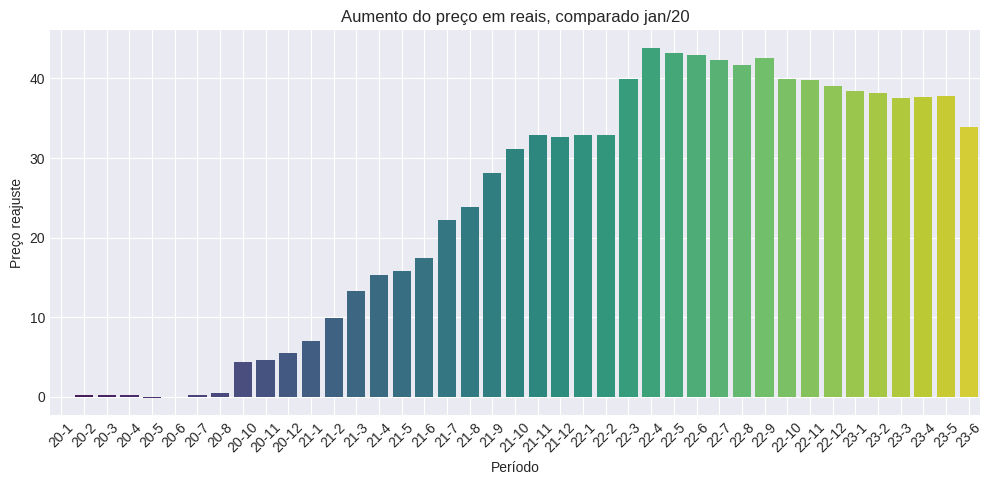

In [63]:
# Serie Temporal
plt.figure( figsize=(12, 5) )
sns.barplot(data=serie_temp.reset_index(), x='ano_mes', y='aumento_preco', palette='viridis')
plt.title('Aumento do preço em reais, comparado jan/20')
plt.xlabel('Período')
plt.ylabel('Preço reajuste')
plt.xticks(rotation=45)
plt.grid(True)

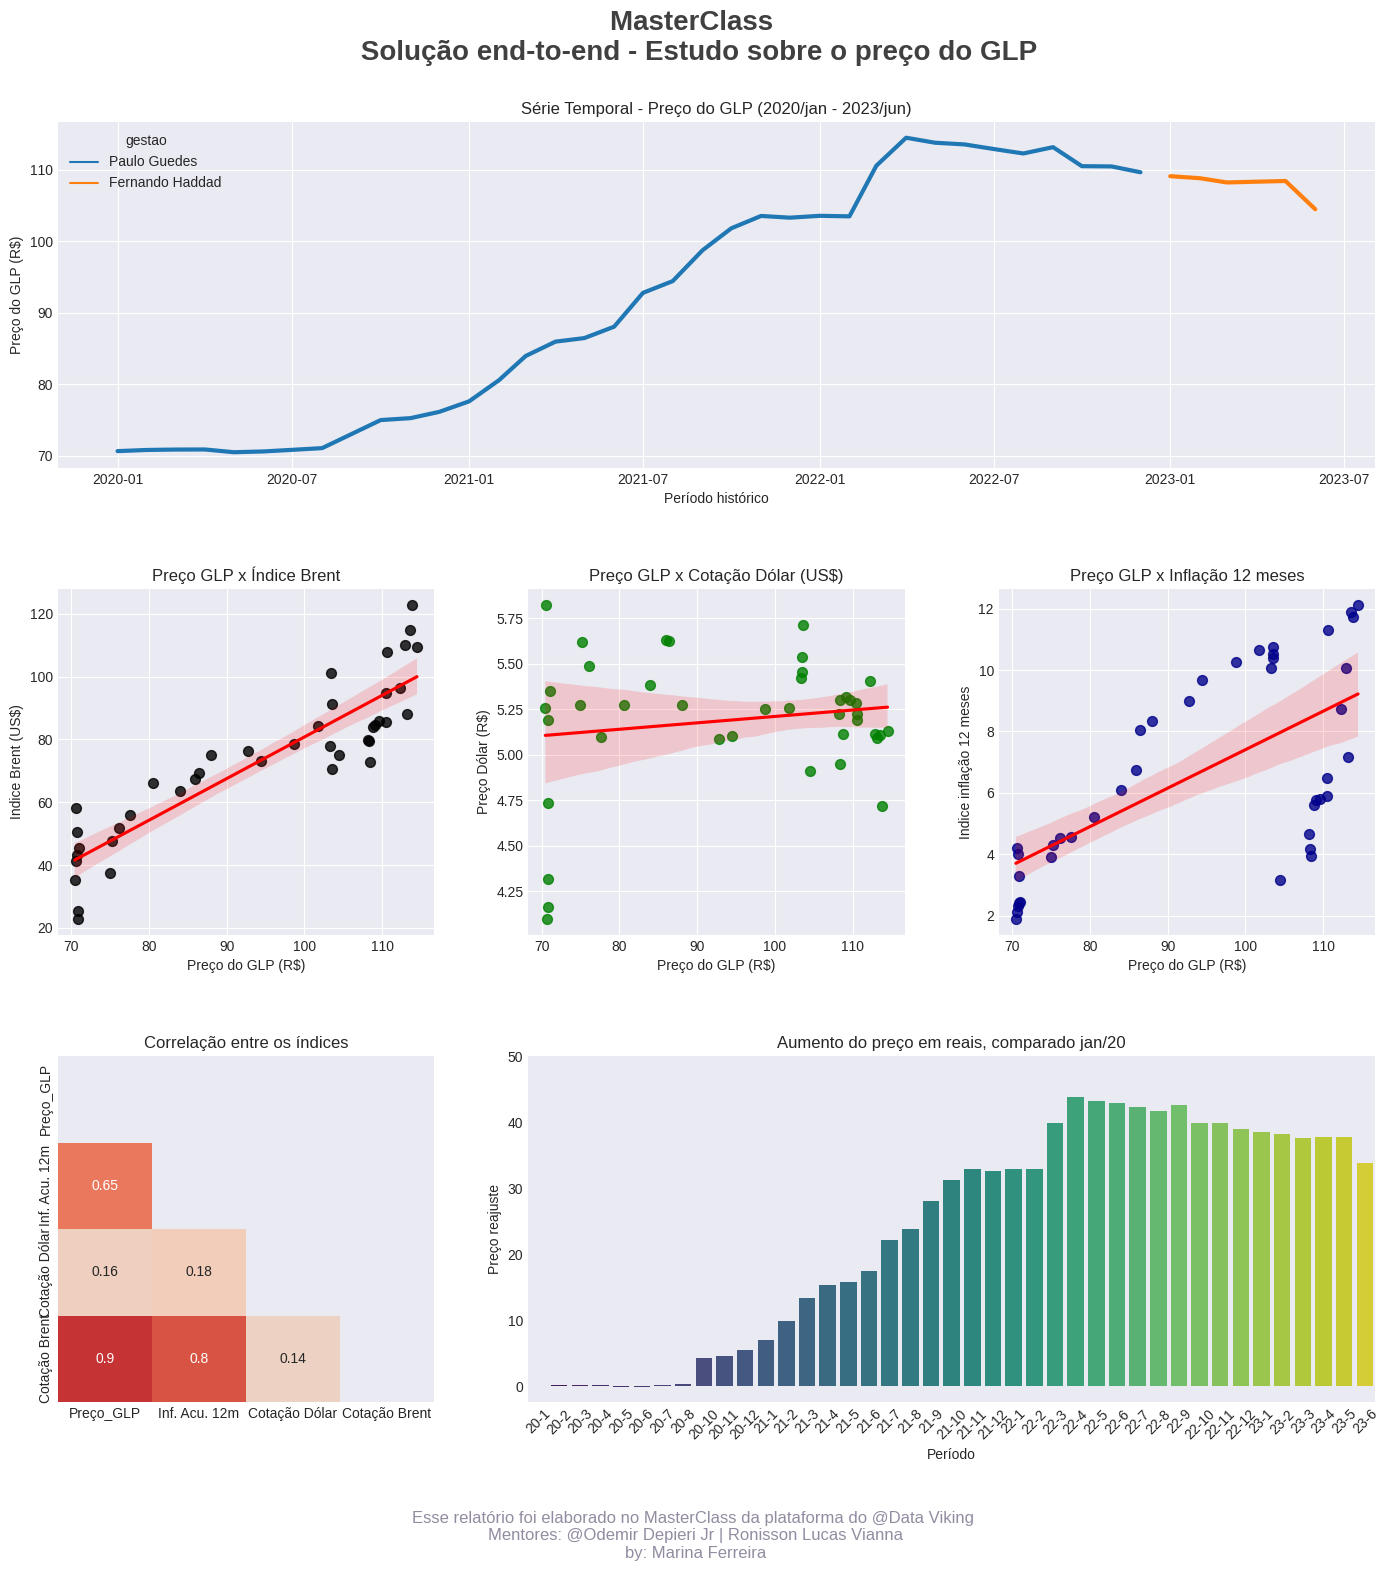

In [65]:
Produto = plt.figure( figsize=(17, 16) ) # initialize figure

# Titulo da figura
plt.suptitle('MasterClass \n Solução end-to-end - Estudo sobre o preço do GLP', fontsize=20, color='#404040', fontweight=600 )

# Lista com os eixos
Eixos = [ None for Loop in range(6) ]

# 3 linhas 3 colunas
Estrutura_Grid = (3, 3)

Eixos[0] = plt.subplot2grid( Estrutura_Grid, (0, 0), colspan=3 )
sns.lineplot(
    data=serie_temp.reset_index(), x='periodo', y='media',
    hue='gestao', linestyle='-', linewidth=3)
plt.title('Série Temporal - Preço do GLP (2020/jan - 2023/jun)')
plt.xlabel('Período histórico')
plt.ylabel('Preço do GLP (R$)')
plt.grid(True)


Eixos[1] = plt.subplot2grid( Estrutura_Grid, (1,0), colspan=1 )
sns.regplot(  data=serie_temp, x='media', y='Indice_Brent', color='black', scatter_kws={'s': 50}, line_kws={'color': 'red'} )
plt.title('Preço GLP x Índice Brent')
plt.xlabel('Preço do GLP (R$)')
plt.ylabel('Indice Brent (US$)')
plt.grid(True)

Eixos[2] = plt.subplot2grid( Estrutura_Grid, (1,1), colspan=1 )
sns.regplot( data=serie_temp, x='media', y='Dolar', color='green', scatter_kws={'s': 50}, line_kws={'color': 'red'} )
plt.title('Preço GLP x Cotação Dólar (US$)')
plt.xlabel('Preço do GLP (R$)')
plt.ylabel('Preço Dólar (R$)')
plt.grid(True)

Eixos[3] = plt.subplot2grid( Estrutura_Grid, (1,2), colspan=1 )
sns.regplot( data=serie_temp, x='media', y='12_Meses', color='darkblue', scatter_kws={'s': 50}, line_kws={'color': 'red'} )
plt.title('Preço GLP x Inflação 12 meses')
plt.xlabel('Preço do GLP (R$)')
plt.ylabel('Indice inflação 12 meses')
plt.grid(True)

Eixos[4] = plt.subplot2grid( Estrutura_Grid, (2,0), colspan=1 )
correlation_matrix = serie_temp[['media', '12_Meses','Dolar', 'Indice_Brent']]
correlation_matrix.columns = ['Preço_GLP', 'Inf. Acu. 12m', 'Cotação Dólar', 'Cotação Brent']
correlation_matrix = correlation_matrix.corr()
mask = np.triu(correlation_matrix)
sns.heatmap( correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, mask=mask)
plt.title('Correlação entre os índices');

Eixos[5] = plt.subplot2grid( Estrutura_Grid, (2,1), colspan=2)
sns.barplot(data=serie_temp.reset_index(), x='ano_mes', y='aumento_preco', palette='viridis')
plt.title('Aumento do preço em reais, comparado jan/20')
plt.xlabel('Período')
plt.ylabel('Preço reajuste')
plt.xticks(rotation=45)
plt.yticks(range(0, 60, 10))

# Ajustar o layout
plt.subplots_adjust( hspace=0.35, wspace=0.25, top=0.91 )

# Rodapé
Rodape = '''
Esse relatório foi elaborado no MasterClass da plataforma do @Data Viking
Mentores: @Odemir Depieri Jr | Ronisson Lucas Vianna
by: Marina Ferreira
'''

# Incluindo o rodape no relatorio
Produto.text( 0.5, 0, Rodape, ha='center', va='bottom', size=12, color='#938ca1');